<a href="https://colab.research.google.com/github/upaq/kalman/blob/master/notebooks/Linear_Gaussian_state_space_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Pip installs

# We have to install these from head due to an update to logsumexp that has
# not yet been updated in the respective packages.
%pip install git+https://github.com/slinderman/pypolyagamma.git
%pip install git+https://github.com/mattjj/pybasicbayes.git
%pip install git+https://github.com/mattjj/pylds.git

%pip install git+https://github.com/upaq/covid19-models.git
%pip install git+https://github.com/upaq/kalman.git

# Comment: pykalman does not have controls, but does do parameter learning.
# Comment: filterpy does not do parameter learning, but has controls!

In [8]:
#@title Imports
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybasicbayes
import pylds
import seaborn as sns
import scipy

from covid_models import CovidData
from covid_models import DynamicBiasCumulative, DynamicBiasDeltas, DynamicBiasDeltasQuadratic, DynamicBiasLogRemainder, DynamicBiasArray
from datetime import datetime, timedelta
from google.colab import files
from IPython.display import clear_output
from kalman import LDS, MCMCSample

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [9]:
#@title Get the data

cd = CovidData(remove_china_correction=True)
print(list(cd.df))

['country_name', 'npi_school_closing', 'npi_workplace_closing', 'npi_cancel_public_events', 'npi_gatherings_restrictions', 'npi_close_public_transport', 'npi_stay_at_home', 'npi_internal_movement_restrictions', 'npi_international_travel_controls', 'npi_income_support', 'npi_debt_relief', 'npi_fiscal_measures', 'npi_international_support', 'npi_public_information', 'npi_testing_policy', 'npi_contact_tracing', 'npi_healthcare_investment', 'npi_vaccine_investment', 'npi_stringency_index', 'npi_masks', 'cases_total', 'cases_new', 'deaths_total', 'deaths_new', 'cases_total_per_million', 'cases_new_per_million', 'deaths_total_per_million', 'deaths_new_per_million', 'tests_total', 'tests_new', 'tests_total_per_thousand', 'tests_new_per_thousand', 'tests_new_smoothed', 'tests_new_smoothed_per_thousand', 'stats_population', 'stats_population_density', 'stats_median_age', 'stats_gdp_per_capita', 'cases_days_since_first', 'deaths_days_since_first', 'iso_3166_2_code', 'census_fips_code', 'mobility

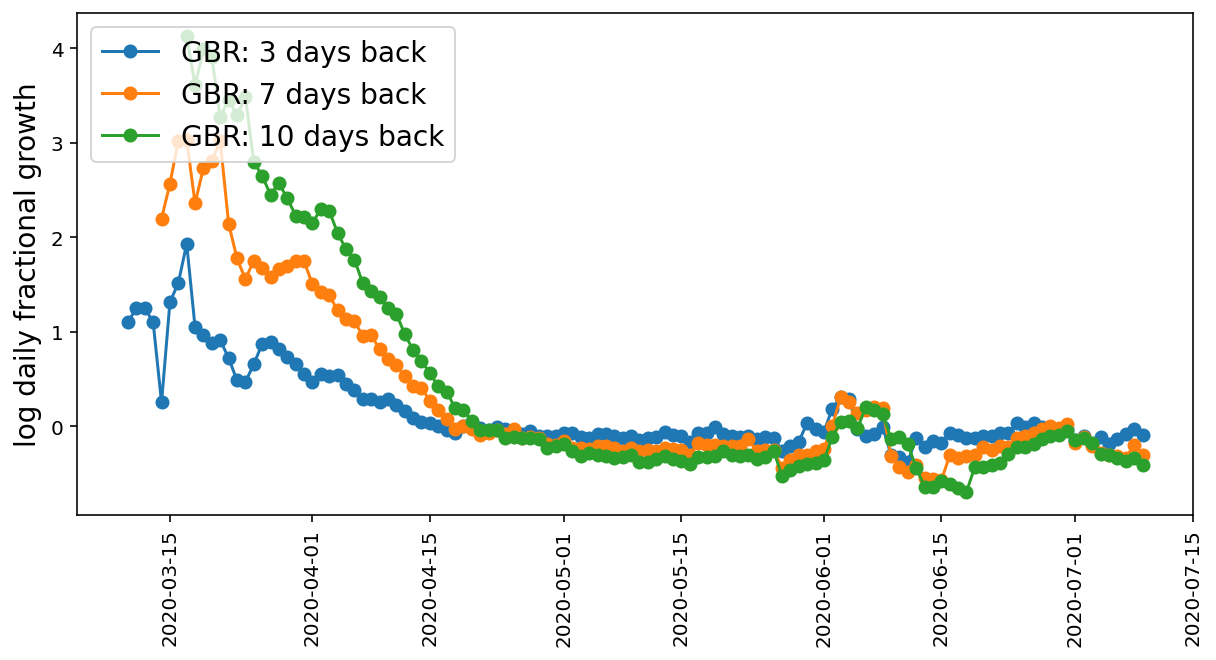

In [10]:
#@title Plotting!

def plot_time_series(isos,
                     smoothed=True,                     
                     cases=False,
                     deaths=False,
                     log_deaths=False,
                     google_mobility=False,
                     testing=False,
                     stringency=False,
                     testing_intensity=False,
                     excess_mortality=False):

  fig, ax = plt.subplots(1, 1, figsize=(10, 6))
  for iso in isos:
    ctry = cd.df.loc[iso]       
    x = ctry.index        # The second index is the date.
    if smoothed:
      if testing:
        y = ctry['rolling_cases'] / ctry['rolling_tests']
        plt.plot(x, y, 'o-', label=iso + ': cases_new[t-6:t] / tests_new[t-6:t]')      
      if testing_intensity:
        y = ctry['rolling_tests'] / ctry['rolling_tests'].max()
        plt.plot(x, y, 'o-', label=iso + ': tests_new[t-6:t] / max(tests_new[*-6:*])')      
      if cases:
        y = 1.0 / 7 * np.log(ctry['chg_cases_windowed'] + 1)
        plt.plot(x, y, 'o-', label=iso + ': log(cases_new[t+1:t+8] / cases_new[t-6:t]) / 7')               
      if deaths:
        temp = np.log(ctry['deaths_week_avg'].shift(periods=+3))        
        y = np.log(ctry['deaths_week_avg'])        
        plt.plot(x, y - temp, 'o-', label=iso + ': 3 days back')      
        temp = np.log(ctry['deaths_week_avg'].shift(periods=+7))  # .fillna('bfill'))
        plt.plot(x, y - temp, 'o-', label=iso + ': 7 days back')      
        temp = np.log(ctry['deaths_week_avg'].shift(periods=+10))  # .fillna('bfill'))
        plt.plot(x, y - temp, 'o-', label=iso + ': 10 days back')      
    else:
      if testing:
        y = ctry['cases_new'] / ctry['tests_new']
        plt.plot(x, y, 'o-', label=iso + ': cases_new[t] / tests_new[t]')      
      if testing_intensity:
        y = ctry['tests_new'] / ctry['tests_new'].max()
        plt.plot(x, y, 'o-', label=iso + ': tests_new[t] / max(tests_new[*])')              
      if cases:
        y = 1.0 / 7 * np.log(ctry['chg_cases_day_min_7'] + 1)
        plt.plot(x, y, 'o-', label=iso + ': log(new_cases[t] / new_cases[t-7]) / 7')      
      if deaths:
        y = np.log(ctry['deaths_week_avg'])
        plt.plot(x, y, 'o-', label=iso + ': log(new_deaths[t] / new_deaths[t-7]) / 7')      
    if log_deaths:
      y = np.log(ctry['deaths_new'])
      y = y.replace([np.inf, -np.inf], np.nan)
      # plt.plot(x, y, 'o-', label=iso + ': log(deaths[t])')

      y = np.log(ctry['deaths_week_avg'])
      y = y.replace([np.inf, -np.inf], np.nan)
      plt.plot(x, y, 'o-', label=iso + ': log(deaths_new[t-3:t+3] / 7)')
    
    k = 2000
    if stringency:
      y = ctry['npi_stringency_index'] * k
      plt.plot(x, y, '--', linewidth=2,
               label=iso + ': Oxford stringency index (scaled)')      

    if google_mobility:      
      y = ctry['mobility_residential'] * k
      plt.plot(x, y, '-', label=iso + ': mobility_residential * ' + str(k))      
      y = ctry['mobility_workplaces'] * k
      plt.plot(x, y, '-', label=iso + ': mobility_workplaces * ' + str(k))

    if excess_mortality:
      y = ctry['deaths_excess_daily_avg']
      plt.plot(x, y, '-', linewidth=3,
               label=iso + ': excess deaths (averaged over week)')
      
      # y = ctry['deaths_new']
      y = ctry['deaths_week_avg']
      plt.plot(x, y, '-', linewidth=3,
               label=iso + ': covid deaths (smoothed 7-day window)')           
      # y = ctry['deaths_excess_weekly'] 
      # plt.plot(x, y, '-', label=iso + ': deaths_excess_weekly')

  if excess_mortality:   
    plt.plot(x, np.zeros(x.shape), ':k')
  
  plt.subplots_adjust(bottom=0.3)  
  plt.xticks(rotation=90)
  if cases or deaths:
    plt.ylabel('log daily fractional growth', fontsize=14)
  plt.legend(loc='upper left', fontsize=14)
  # plt.ylim(-2, 20)
  plt.show()

plot_time_series(['GBR'], # 'GBR', 'NLD', 'ITA', 'ESP'],
                 # ['ITA', 'KOR', 'NLD', 'USA', 'ZAF', 'GBR'],
                 # ['ITA', 'NLD', 'SWE'],
                 smoothed=True,                     
                 cases=False,
                 deaths=True,
                 log_deaths=False,
                 google_mobility=False,
                 testing=False,
                 stringency=False,
                 testing_intensity=False,
                 excess_mortality=False)

USING 49 COUNTRIES:
['ARG', 'AUT', 'BEL', 'BGD', 'BRA', 'CAN', 'CHE', 'CHL', 'CHN', 'COL', 'CZE', 'DEU', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP', 'FIN', 'FRA', 'GBR', 'GRC', 'HUN', 'IDN', 'IND', 'IRL', 'IRN', 'ISR', 'ITA', 'JPN', 'KOR', 'MAR', 'MEX', 'NLD', 'NOR', 'PAK', 'PAN', 'PER', 'PHL', 'POL', 'PRT', 'ROU', 'RUS', 'SAU', 'SRB', 'SWE', 'TUR', 'UKR', 'USA']


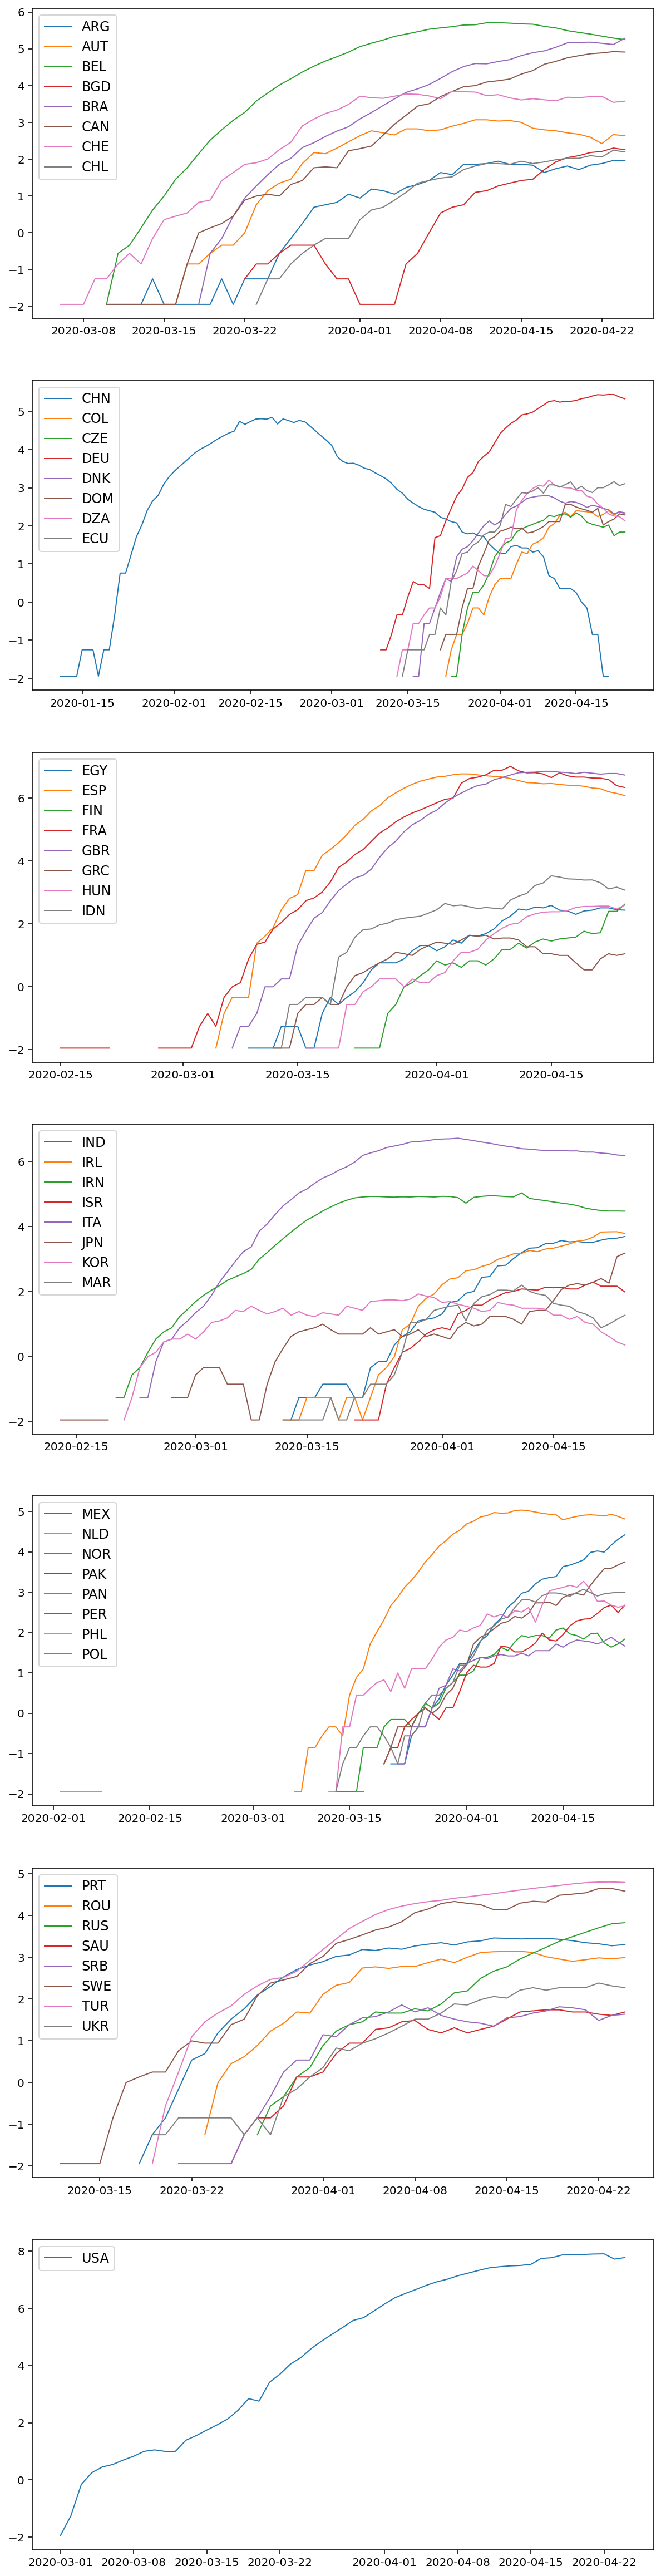

In [18]:
# The last date in the time series. Could be None to include everything.
MAX_DATE = datetime(2020, 4, 24)

isos = cd.countries_with_cumulative_mortality_greater_than(100, MAX_DATE)
isos_to_plot = isos.copy()

UNUSUAL_REPORTING = []

isos = [iso for iso in isos if iso not in UNUSUAL_REPORTING]
print('USING', len(isos), 'COUNTRIES:')
print(isos)

# All the controls in the Linear Dynamical System:
NPIS = ['npi_stringency_index']

COUNTRY_BIAS = True
GLOBAL_BIAS = True
DYNAMIC_BIAS = None
# DYNAMIC_BIAS = DynamicBiasDeltas([2, 4, 6])
# DYNAMIC_BIAS = DynamicBiasDeltasQuadratic([2, 4, 6])
# DYNAMIC_BIAS = DynamicBiasLogRemainder()
# DYNAMIC_BIAS = DynamicBiasArray([
#         DynamicBiasDeltasQuadratic([2, 4, 6]),
#         DynamicBiasLogRemainder()])

WEEKS_BACK = 8

# How far into the future do we want to predict?
FUTURE_DAYS = 35

# Do we sample the control / emission matrices as well?
IDENTITY_TRANSITION_MATRIX = True
FIXED_EMISSION_MATRIX = False

dim = 0 if DYNAMIC_BIAS is None else DYNAMIC_BIAS.dim
D_obs = 1
D_latent = 1
D_input = (WEEKS_BACK * len(NPIS)
           + int(GLOBAL_BIAS)
           + int(COUNTRY_BIAS) * len(isos)
           + dim)

# D_input_gamma = 0  # The most intuitive posterior in B. There is no country-
                     # specific scaling of NPIs if D_input_gamma = 0.
D_input_gamma = WEEKS_BACK * len(NPIS)

lds = LDS(D_obs, D_latent, D_input,
          D_input_gamma=D_input_gamma,
          dynamics_prior_scalar=10.0)

lds.set_parameters(gamma_prior_precision=10,
                   gamma_prior_mean_times_precision=10)                   

# The number of MCMC samples
N_samples = 20000

delta = len(isos_to_plot) % 8
num_plots = int(len(isos_to_plot) / 8)
num_plots = num_plots if delta == 0 else num_plots + 1

fig, ax = plt.subplots(num_plots, 1, figsize=(10, 6 * num_plots))
for plot in range(num_plots):
  for idx in range(8):
    country_index = plot * 8 + idx
    if country_index < len(isos_to_plot):    
      iso = isos_to_plot[country_index]
      ctry = cd.df.loc[iso]       
      if MAX_DATE is not None:
        ctry = ctry.loc[:MAX_DATE]  
      x = ctry.index        # The second index is the date.  
      y = np.log(ctry['deaths_week_avg'])
      y = y.replace([np.inf, -np.inf], np.nan)

      lw = 1
      if iso in UNUSUAL_REPORTING:
        lw = 4
      ax[plot].plot(x, y, '-', lw=lw, label=iso)
    ax[plot].legend(loc='upper left', ncol=1, fontsize=12)

plt.show()

Done 0 samples at 2020-07-10 11:34:10.702022
Done 500 samples at 2020-07-10 11:34:45.606919
Done 1000 samples at 2020-07-10 11:35:20.553186
Done 1500 samples at 2020-07-10 11:35:55.582224
Done 2000 samples at 2020-07-10 11:36:30.438289
Done 2500 samples at 2020-07-10 11:37:05.451539
Done 3000 samples at 2020-07-10 11:37:40.469099
Done 3500 samples at 2020-07-10 11:38:15.505473
Done 4000 samples at 2020-07-10 11:38:50.403237
Done 4500 samples at 2020-07-10 11:39:25.414555
Done 5000 samples at 2020-07-10 11:40:00.400851
Done 5500 samples at 2020-07-10 11:40:35.346356
Done 6000 samples at 2020-07-10 11:41:10.345344
Done 6500 samples at 2020-07-10 11:41:45.298192
Done 7000 samples at 2020-07-10 11:42:20.205499
Done 7500 samples at 2020-07-10 11:42:55.103453
Done 8000 samples at 2020-07-10 11:43:30.048311
Done 8500 samples at 2020-07-10 11:44:04.997476
Done 9000 samples at 2020-07-10 11:44:39.942298
Done 9500 samples at 2020-07-10 11:45:14.983744
Done 10000 samples at 2020-07-10 11:45:49.84

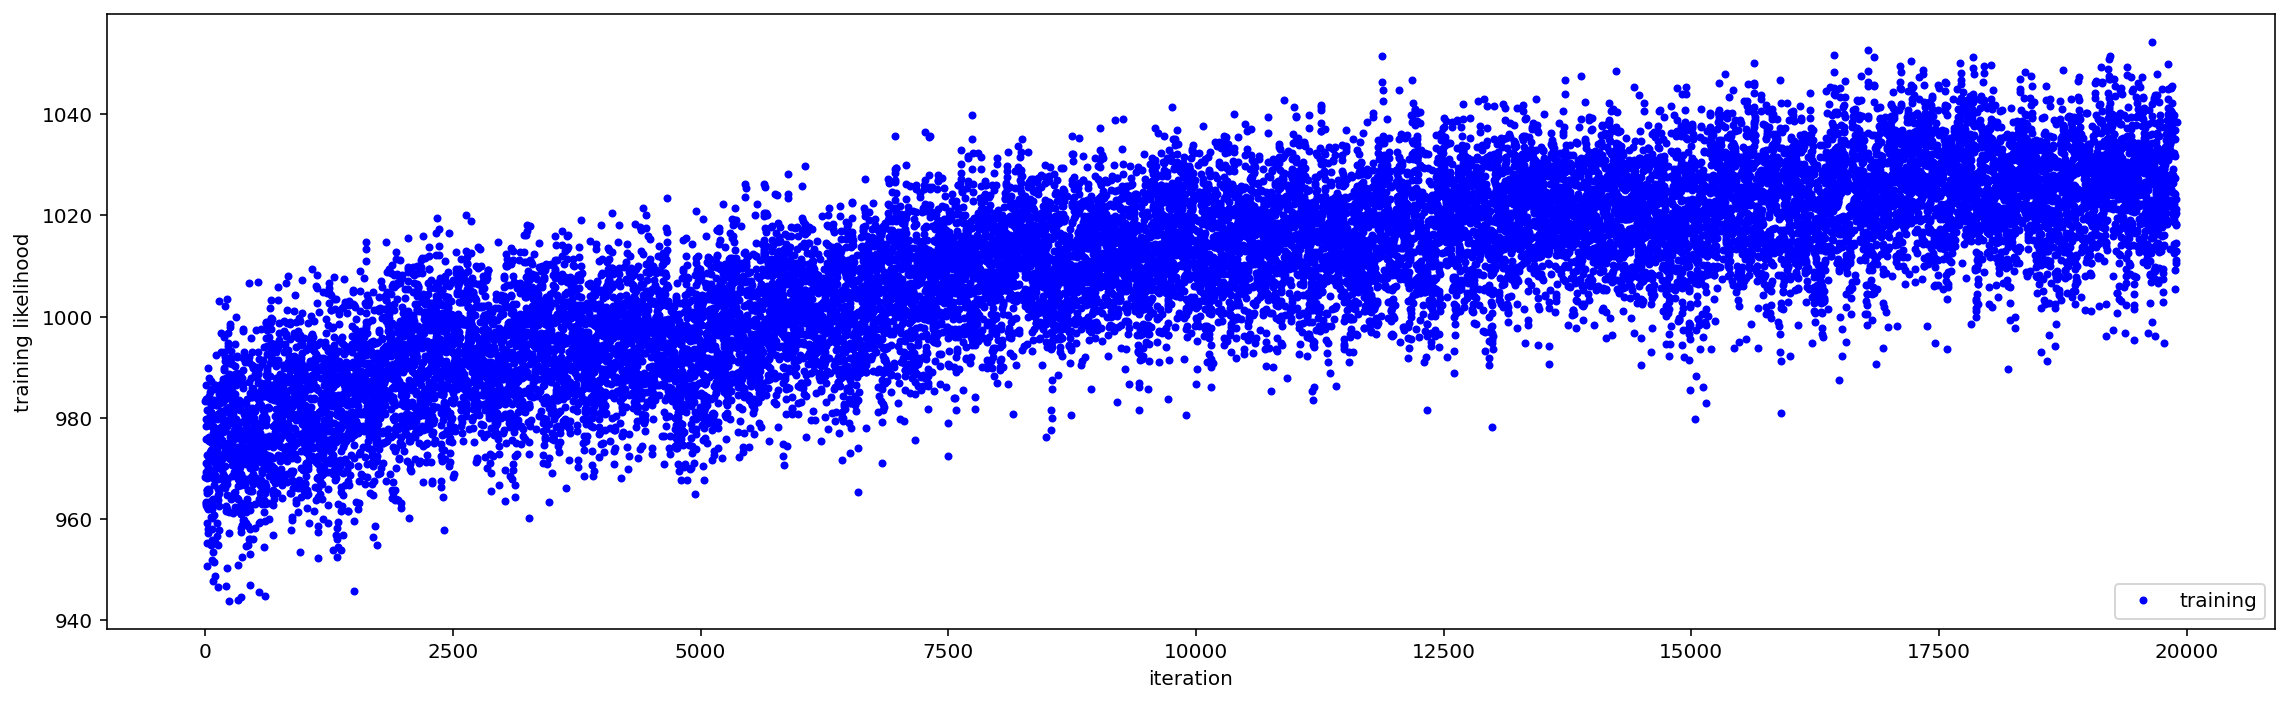

In [19]:
#@title Sample!

# Add the data to the model.
for idx in range(len(isos)):
  iso = isos[idx]
  x, controls, _, _ = cd.get_country_data(iso, 
                                          NPIS,
                                          exclude_weekly_average_below=1.0,                                        
                                          max_date=MAX_DATE,
                                          weeks_back=WEEKS_BACK,                                    
                                          global_bias=GLOBAL_BIAS,
                                          country_bias=COUNTRY_BIAS,
                                          country_index=idx,
                                          total_countries=len(isos),
                                          dynamic_bias=DYNAMIC_BIAS,
                                          future_days=1) 
  if x is not None and len(x) > 14 and controls is not None:
    x = x.to_numpy()
    x = np.reshape(x, (-1, 1))    
    lds.add_data(x, inputs=controls)    
  else:
    print('Skipping ' + iso)

# Run the Gibbs sampler.
mcmc_samples = []
lls = []

# Assuming the initial parameters are decent, first sample states.
lds.resample_states()

for i in range(N_samples):
  if i % 500 == 0:
    print('Done', i, 'samples at', datetime.now())

  sample, likelihood = lds.resample_model(
      identity_transition_matrix=IDENTITY_TRANSITION_MATRIX,
      fixed_emission_matrix=FIXED_EMISSION_MATRIX)  
  mcmc_samples.append(sample)
  lls.append(likelihood)

print(mcmc_samples[-1])

# Plot the log likelihoods
plt.figure(figsize=(16,5))
plt.plot(np.arange(N_samples - 100), lls[100:], '.b', label='training')
plt.xlabel('iteration')
plt.ylabel('training likelihood')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

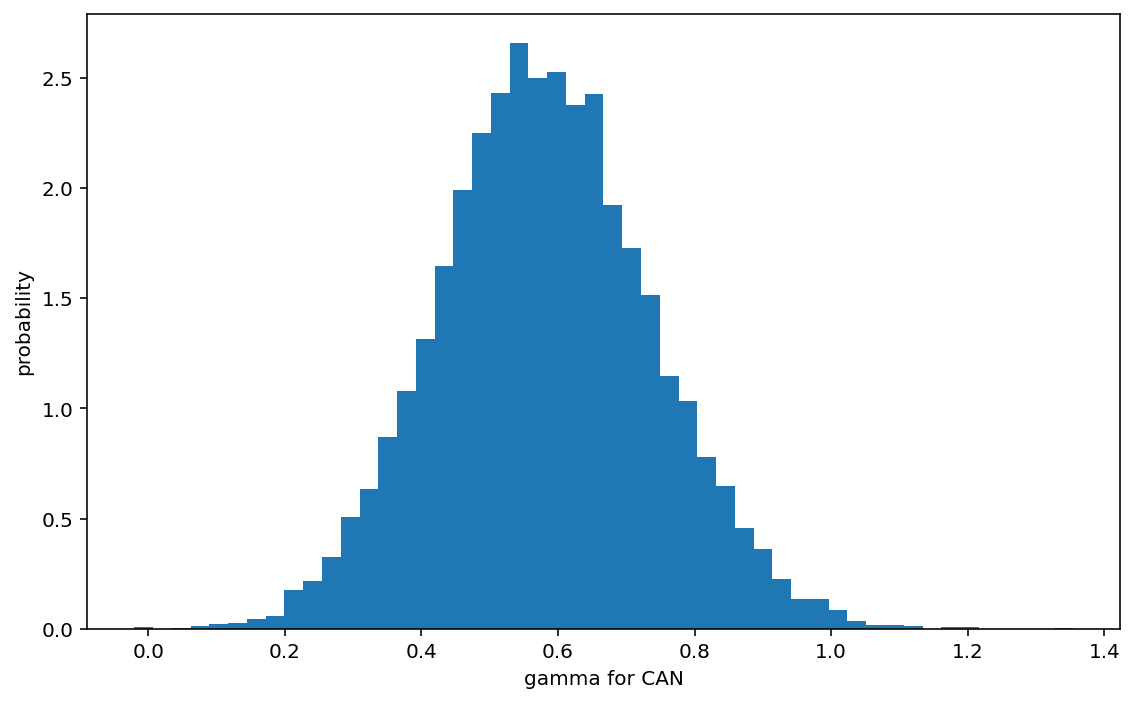

In [20]:
#@title Plot gamma example

idx = 5
iso = isos[idx]

gammas = []
for i, sample in enumerate(mcmc_samples):
  if i > N_samples / 2:
    gammas.append(sample.gamma[idx])

plt.figure(figsize=(8,5))
plt.hist(gammas, density=True, bins=50)  # `density=False` would make counts
plt.ylabel('probability')
plt.xlabel('gamma for ' + iso);
plt.tight_layout()
plt.show()

In [21]:
# Some settings for making predictions...
# Include state noise when sampling future trajectories, or not.
FUTURE_STATES_NOISE = True
ISO = 'DEU'

ctry = cd.df.loc[ISO]
week_one = MAX_DATE + pd.Timedelta('7 days')
week_two = MAX_DATE + pd.Timedelta('14 days')
week_three = MAX_DATE + pd.Timedelta('21 days')
week_one_deaths = int(ctry.loc[week_one]['rolling_deaths'])
week_two_deaths = int(ctry.loc[week_two]['rolling_deaths'])
week_three_deaths = int(ctry.loc[week_three]['rolling_deaths'])
print('Evaluation max date', MAX_DATE)
print('One week ahead     ', week_one, '|', week_one_deaths)
print('Two weeks ahead    ', week_two, '|', week_two_deaths)
print('Three weeks ahead  ', week_three, '|', week_three_deaths)
print('One + two weeks ahead         ', week_one_deaths + week_two_deaths)
print('One + two + three weeks ahead ',
      week_one_deaths + week_two_deaths + week_three_deaths)

Evaluation max date 2020-04-24 00:00:00
One week ahead      2020-05-01 00:00:00 | 967
Two weeks ahead     2020-05-08 00:00:00 | 978
Three weeks ahead   2020-05-15 00:00:00 | 558
One + two weeks ahead          1945
One + two + three weeks ahead  2503


In [22]:
#@title Predictions!
idx = isos.index(ISO)
ctry = cd.df.loc[ISO]

(x_df, controls, future_controls,
 country_df) = cd.get_country_data(ISO,
                                   NPIS,                                                
                                   exclude_weekly_average_below=1.0,
                                   max_date=MAX_DATE,
                                   weeks_back=WEEKS_BACK,
                                   global_bias=GLOBAL_BIAS,
                                   country_bias=COUNTRY_BIAS,
                                   country_index=idx,
                                   total_countries=len(isos),
                                   dynamic_bias=DYNAMIC_BIAS,
                                   alpha=1.0,
                                   future_days=FUTURE_DAYS)
x = x_df.to_numpy()
x = np.reshape(x, (-1, 1))    
    
(_, _, future_controls_0,
 _) = cd.get_country_data(ISO,
                          NPIS,                                                
                          exclude_weekly_average_below=1.0,
                          max_date=MAX_DATE,
                          weeks_back=WEEKS_BACK,
                          global_bias=GLOBAL_BIAS,
                          country_bias=COUNTRY_BIAS,
                          country_index=idx,
                          total_countries=len(isos),
                          dynamic_bias=DYNAMIC_BIAS, 
                          alpha=0.0,
                          future_days=FUTURE_DAYS)

# Sanity checking the final control vectors!
print(controls[-1, :])
print(future_controls[-1, :])

future_xs = []
future_xs_0 = []

x_means = np.zeros(x.shape)
x_covs = np.zeros((x.shape[0], D_obs, D_obs))
z_means = np.zeros((x.shape[0], D_latent))            # The smoothed means
z_covs = np.zeros((x.shape[0], D_latent, D_latent))   # The smoothed covariances

# We'll use 20 MCMC samples in plotting. Hopefully spaced out enough to be
# independent. We didn't do any autocorrelation plots from the Gibbs chain.
last_sample = len(mcmc_samples)
first_sample = int(last_sample / 2)
step = int((last_sample - first_sample) / 1000)
step = step if step > 0 else 1

samples_added = 0
for i in range(first_sample, last_sample, step):
  samples_added += 1

  # Initialize an LDS model from the MCMC sampled parameters.  
  sample = mcmc_samples[i]
  pred_lds = LDS(D_obs, D_latent, D_input, WEEKS_BACK * len(NPIS))
  pred_lds.set_parameters(A=sample.A, B=sample.B, sigma_states=sample.Q,
                          C=sample.C, D=sample.D, sigma_obs=sample.R)
  gamma = sample.gamma[idx]

  smoothed_x_mean, smoothed_x_cov, obs = pred_lds.infer_and_forward_sample(
       x, controls, gamma, FUTURE_DAYS, future_inputs=future_controls,
       dynamic_bias=DYNAMIC_BIAS, country_df=country_df,            
       states_noise=FUTURE_STATES_NOISE, obs_noise=True)
   
  x_means += smoothed_x_mean
  mu = np.expand_dims(smoothed_x_mean, 2)  

  # We have a predictive Gaussian distribution for each MCMC parameter sample,
  # and the covariance of the mixture has the form in
  # https://en.wikipedia.org/wiki/Mixture_distribution, where we add mu*mu^T per
  # component, and substract the average mean outer product again.        
  x_covs += smoothed_x_cov + np.matmul(mu, np.transpose(mu, (0, 2, 1)))
    
  future_xs.append(obs)

  _, _, obs = pred_lds.infer_and_forward_sample(
       x, controls, gamma, FUTURE_DAYS, future_inputs=future_controls_0,
       dynamic_bias=DYNAMIC_BIAS, country_df=country_df,
       states_noise=FUTURE_STATES_NOISE, obs_noise=True)
  
  future_xs_0.append(obs)

x_means /= samples_added
x_covs /= samples_added
mu = np.expand_dims(x_means, 2)  
x_covs -= np.matmul(mu, np.transpose(mu, (0, 2, 1)))
# See earlier comment on https://en.wikipedia.org/wiki/Mixture_distribution

# z_means /= samples_added
# z_covs /= samples_added
# mu = np.expand_dims(z_means, 2)  
# z_covs -= np.matmul(mu, np.transpose(mu, (0, 2, 1)))

x_means = x_means.flatten()
x_covs = x_covs.flatten()

future_average = np.zeros((FUTURE_DAYS, 1))
real_predictions = np.zeros((FUTURE_DAYS, 1))
for x_future in future_xs:
  future_average += x_future
  real_predictions += np.exp(x_future)
future_average /= len(future_xs)
real_predictions /= len(future_xs)

future_0_average = np.zeros((FUTURE_DAYS, 1))
for x_future in future_xs_0:
  future_0_average += x_future
future_0_average /= len(future_xs_0)

week_one_predicted = int(real_predictions[6] * 7)
week_one_two_predicted = int(real_predictions[6] * 7 +
                             real_predictions[13] * 7)
week_one_two_three_predicted = int(real_predictions[6] * 7 +
                                   real_predictions[13] * 7 +
                                   real_predictions[20] * 7)
week_one_predicted_exp = int(7 * np.exp(future_average[6]))
week_one_two_predicted_exp = int(7 * np.exp(future_average[6]) +
                                 7 * np.exp(future_average[13]))
week_one_two_three_predicted_exp = int(7 * np.exp(future_average[6]) +
                                       7 * np.exp(future_average[13]) + 
                                       7 * np.exp(future_average[20]))

print('ISO & $T$ & truth & pred & $\Delta$ & \\% \\\\ \\hline')
print(ISO,  '& 7 &', week_one_deaths, '&', week_one_predicted,
      '&', week_one_deaths - week_one_predicted, '&',
      '{0:.1f}\\%'.format(week_one_predicted / week_one_deaths * 100 - 100),
      '\\\\')
print(' & 7 &', week_one_deaths, '&', week_one_predicted_exp,
      '(e) &', week_one_deaths - week_one_predicted_exp, '&',
      '{0:.1f}\\%'.format(week_one_predicted_exp / week_one_deaths * 100 - 100),
      '\\\\')

week_one_two_deaths = week_one_deaths + week_two_deaths
print(' & 14 &', week_one_two_deaths, '&', week_one_two_predicted,
      '&', week_one_two_deaths - week_one_two_predicted, '&',
      '{0:.1f}\\%'.format(week_one_two_predicted / week_one_two_deaths * 100 - 100),
      '\\\\')
print(' & 14 &', week_one_two_deaths, '&', week_one_two_predicted_exp,
      '(e) &', week_one_two_deaths - week_one_two_predicted_exp, '&',
      '{0:.1f}\\%'.format(week_one_two_predicted_exp / week_one_two_deaths * 100 - 100),
      '\\\\')

week_one_two_three_deaths = (week_one_deaths + week_two_deaths +
                             week_three_deaths)
print(' & 21 &', week_one_two_three_deaths, '&',
      week_one_two_three_predicted,
      '&', week_one_two_three_deaths - week_one_two_three_predicted, '&',
      '{0:.1f}\\%'.format(week_one_two_three_predicted / week_one_two_three_deaths * 100 - 100),
      '\\\\')
print(' & 21 &', week_one_two_three_deaths, '&',
      week_one_two_three_predicted_exp,
      '(e) &', week_one_two_three_deaths - week_one_two_three_predicted_exp, '&',
      '{0:.1f}\\%'.format(week_one_two_three_predicted_exp / week_one_two_three_deaths * 100 - 100),
      '\\\\')

[0.24205714 0.28901429 0.41467143 0.7024     0.7315     0.7315
 0.7315     0.7315     1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[0.7315 0.7315 0.7315 0.7315 0.7315 0.7315 0.7315 0.7315 1.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 1.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.    ]
ISO & $T$ & truth & pred &

In [23]:
save_figure = False

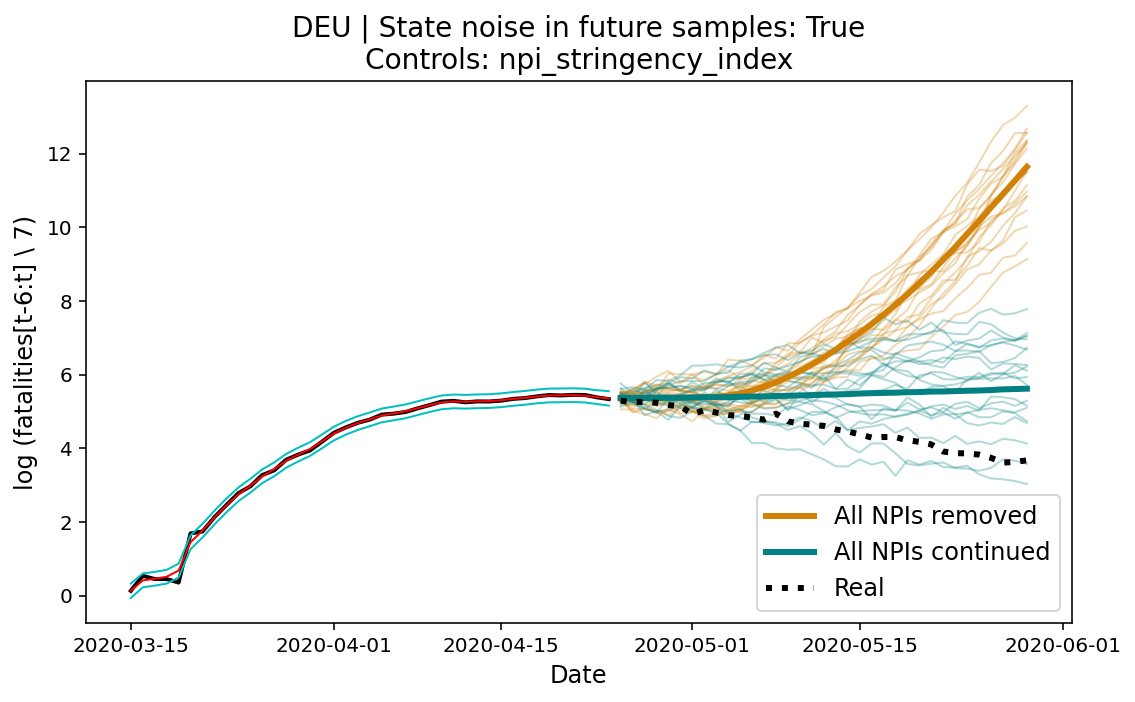

11


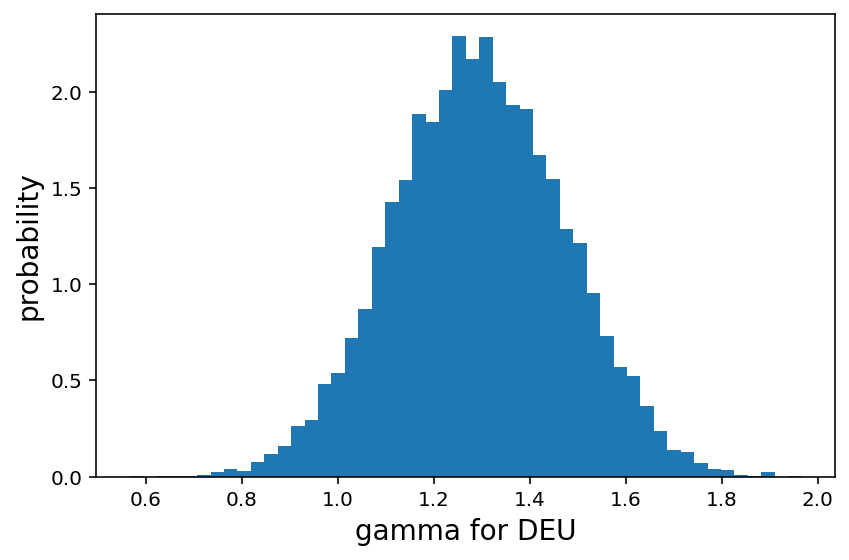

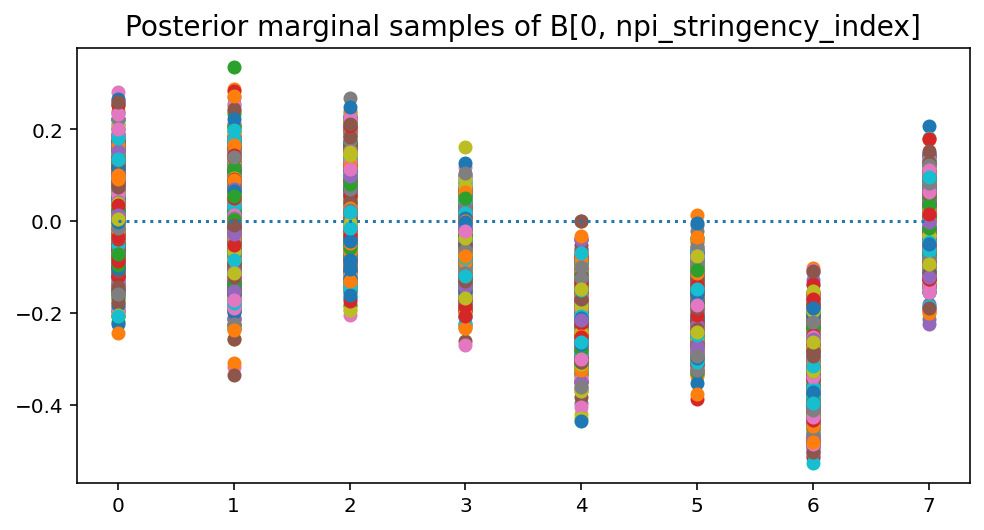

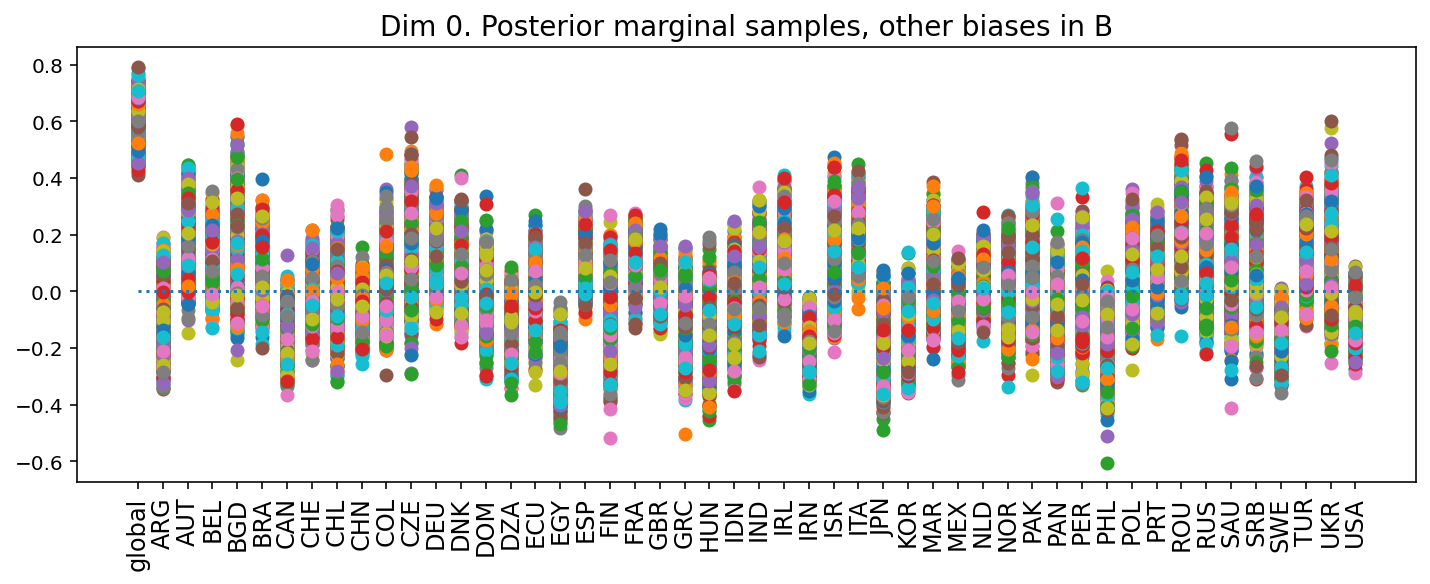

In [25]:
#@title Plots

xidx_future = pd.date_range(
    start=(x_df.index.max() + timedelta(days=1)),
    freq='1d', periods=FUTURE_DAYS)
xidx = x_df.index.append(xidx_future)

x_fut_df = cd.get_x(ISO,
                    x_df.index.max() + timedelta(days=1),
                    x_df.index.max() + timedelta(days=FUTURE_DAYS))
                 
# Plot the predictions going forward.
plt.figure(figsize=(8, 5))
plt.plot(x_df.index, x, color='k', lw=2)         
plt.plot(x_df.index, x_means, color='r', lw=1)         
plt.plot(x_df.index, x_means + 2 * np.sqrt(x_covs), color='c', lw=1)         
plt.plot(x_df.index, x_means - 2 * np.sqrt(x_covs), color='c', lw=1)

# Future with no control.
counter = 0
for y, y_0 in zip(future_xs, future_xs_0):
  if counter % 50 == 0:
    plt.plot(xidx_future, y_0,
            color=(208 / 255.0, 129 / 255.0, 6 / 255.0), lw=1, alpha=0.3)
    plt.plot(xidx_future, y,
            color=(0 / 255.0, 128 / 255.0, 129 / 255.0), lw=1, alpha=0.3)
  counter += 1

plt.plot(xidx_future, future_0_average,
         color=(208 / 255.0, 129 / 255.0, 6 / 255.0), lw=3,
         label='All NPIs removed')
plt.plot(xidx_future, future_average,
         color=(0 / 255.0, 128 / 255.0, 129 / 255.0), lw=3,
         label='All NPIs continued')
plt.plot(x_fut_df, ':k', lw=3, label='Real')

plt.xlabel('Date', fontsize=12)
plt.ylabel('log (fatalities[t-6:t] \ 7)', fontsize=12)
plt.legend(loc='lower right', ncol=1, fontsize=12)

controls_str = ''
counter = 0
for npi in NPIS:
  if counter > 0:
    if counter % 4 == 0:
      controls_str += '\n'
    else:
      controls_str += ', '
  controls_str += npi
  counter += 1

plt.title(ISO + ' | '
          + 'State noise in future samples: ' + str(FUTURE_STATES_NOISE)
          + '\nControls: ' + controls_str,
          fontsize=14)
plt.tight_layout()
if save_figure:
  plt.savefig(ISO + '.pdf')
  files.download(ISO + '.pdf') 
else:
  plt.show()

# Plot gamma samples for country
gammas = []
print(idx)
for i, sample in enumerate(mcmc_samples):
  if i > N_samples / 2:
    gammas.append(sample.gamma[idx])

plt.figure(figsize=(6,4))
plt.hist(gammas, density=True, bins=50)  # `density=False` would make counts
plt.ylabel('probability', fontsize=14)
plt.xlabel('gamma for ' + ISO, fontsize=14)
plt.tight_layout()
plt.show()

# Plot the latent states
if False:
  plt.figure(figsize=(8, 5))
  # plt.plot(np.arange(x.shape[0]), x, color='k', lw=2, label='observed')
  for i in range(D_latent):
    plt.plot(x_df.index, z_means[:, i], lw=2,
          label='z[' + str(i) + '] (marginal mean)')
    plt.plot(x_df.index, z_means[:, i] + 2 * np.sqrt(z_covs[:, i, i]),
            color='c', lw=1)
    plt.plot(x_df.index, z_means[:, i] - 2 * np.sqrt(z_covs[:, i, i]),
            color='c', lw=1)

  plt.xlabel('Date', fontsize=14)
  plt.legend(loc='upper left', ncol=1, fontsize=14)
  plt.title(ISO + ': latent variables',
            fontsize=14)
  plt.tight_layout()
  plt.show()

# Plot some posterior marginal samples for the intervention components.
fig, ax = plt.subplots(len(NPIS), D_latent,
                       figsize=(8 * D_latent, 4 * len(NPIS)))
one_dim_ax = True if len(NPIS) == 1 or D_latent == 1 else False
one_ax = True if len(NPIS) == 1 and D_latent == 1 else False

for c in range(len(NPIS)):
  for i in range(D_latent):
    if one_ax:
      a = ax    
    elif one_dim_ax:
      a = ax[c * len(NPIS) + i]
    else: 
      a = ax[c, i]
    for sample_idx in range(first_sample, last_sample, step):
      sample = mcmc_samples[sample_idx]      
      b = sample.B[i, 0:WEEKS_BACK * len(NPIS)]      
      b = b.reshape((WEEKS_BACK, -1))
      # The controls were one row per week, one column per control, and need to
      # keep that structure when unpacked.
      a.plot(b[:, c], 'o')
    a.plot(range(WEEKS_BACK), np.zeros(WEEKS_BACK), ':')
    a.set_title('Posterior marginal samples of B[' + str(i) + ', ' + NPIS[c] + ']', fontsize=14)
plt.show()

# Plot some posterior marginal samples for the biases (global and
# country-specific).
fig, ax = plt.subplots(1, D_latent, figsize=(12 * D_latent, 4))
one_ax = True if D_latent == 1 else False

db_list = []
if DYNAMIC_BIAS:
  db_list = ['t-3', 't-7', 't-10']

for i in range(D_latent):
  if one_ax:
    a = ax        
  else: 
    a = ax[i]
  for sample_index in range(first_sample, last_sample, step):
    sample = mcmc_samples[sample_index]    
    b = sample.B[i, WEEKS_BACK * len(NPIS):]  
    a.plot(b, 'o')
  a.plot(range(int(GLOBAL_BIAS) + int(COUNTRY_BIAS) * len(isos)),
         np.zeros(int(GLOBAL_BIAS) + int(COUNTRY_BIAS) * len(isos)), ':')
  a.set_title('Dim ' + str(i) + '. Posterior marginal samples, other biases in B', fontsize=14)
  a.set_xticks(range(int(GLOBAL_BIAS) + int(COUNTRY_BIAS) * len(isos) + 
                     (0 if DYNAMIC_BIAS is None else DYNAMIC_BIAS.dim)))
  if GLOBAL_BIAS:
    a.set_xticklabels(['global'] + isos + db_list, rotation='vertical', fontsize=12)
  else:
    a.set_xticklabels(isos + db_list, rotation='vertical', fontsize=12)  
plt.show()